In [39]:
library("DESeq2")
library("affy")
source("helper.R")
library("naivebayes")
library("stringr")
library("ggplot2")
library("GenomicRanges")
library("ggfortify")

#alt.read.counts.txt <- "/media/scott/Zapdos/gtex/alt.counts.txt"
#hg38.read.counts.txt <- "/media/scott/Zapdos/gtex/hg38.counts.txt"
#run.info.txt <- "/media/scott/Zapdos/gtex/run_info.txt"
#chr7.gtf <- "/media/scott/Zapdos/gtex/chr7.gtf"

#alt.read.counts <- read.table(alt.read.counts.txt, header=TRUE)
#hg38.read.counts <- read.table(hg38.read.counts.txt, header=TRUE)

#run.info <- read.table(run.info.txt, header=TRUE, sep="\t")

PRSS1="ENSG00000274247.4"
PRSS3P1="ENSG00000282295.1"
PRSS3P2="ENSG00000282667.1"
TRY7="ENSG00000282565.1"
PRSS2="ENSG00000282049.1"

GENES <- c(PRSS1, PRSS3P1, PRSS3P2, TRY7, PRSS2)
GENE_NAMES <- c("PRSS1", "PRSS3P1", "PRSS3P2", "TRY7", "PRSS2")

In [2]:
load_gtex_genotypes()

[1] "LOADING GTEX WGS DATA"
[1] "GTEX MATRIX: gtex.matrix"
[1] "RUN INFORMATION: run.df"
[1] "GTEX PHENOTYPES: gtex.df"
[1] "READ COUNTS: count.matrix"


In [3]:
load_sequencing_data()

[1] "LOADING SEQUENCING DATA"
[1] "PHENOTYPE DATA: seq.df"
[1] "GENOTYPE MATRIX: gt.matrix"
[1] "HAPLOTYPE MATRIX: hap.matrix"
[1] "-----------------------"
[1] "FILTERING VARIANTS BETWEEN 779590:779600 (low confidence homopolymer T calls)"
[1] "FILTERING VARIANTS THAT SHARE POS WITH OTHER VARIANTS"
[1] "FILTERING 2 SAMPLES"
[1] "FILTERING VARIANTS WITH MINOR ALLELE COUNT < 2"
[1] "MINOR ALLELE COUNTS: variant.df"
[1] "-----------------------"
[1] "# individuals = 1427"
[1] "# variants = 232"


In [19]:
load_gtex_pairs()

[1] "PAIR DATA: pair.df"


In [4]:
# takes some time...
imputed.hap.mat <- impute_hap_matrix(hap.matrix, k=5)


  A   B   C   D 
255   3   3 203 


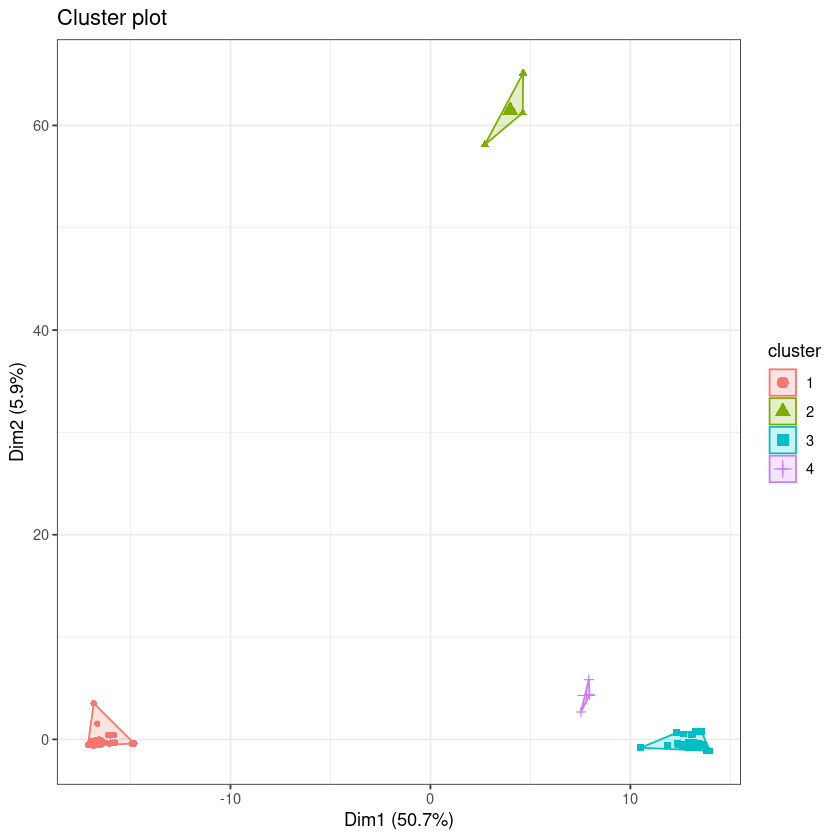

In [5]:
START_CLUSTER <- 748818
END_CLUSTER   <- 799779

mat <- imputed.hap.mat[as.numeric(rownames(imputed.hap.mat)) > START_CLUSTER &
                      as.numeric(rownames(imputed.hap.mat)) < END_CLUSTER,]
#mat[mat < 0] <- 0
clusters <- kmeans_cluster_haplotypes(mat, k=4, plot.clusters=TRUE)

rep <- c("QUL28163_03A.1", "OSK7719_03A.1", "BSP21041_03A.2", "OSK7706_03A.1")
labels <- "ABCD"

clusters <- label_clusters(clusters, rep, labels)

In [6]:
split_id <- function(x){ return(strsplit(x, split=c("\\."))[[1]][1]) }
split_num <- function(x){ return(strsplit(x, split=c("\\."))[[1]][2]) }

get_hap_group <- function(hap, clust){ return(clust$hap.df[clust$hap.df$sample == hap,]$cluster) }

bootstrap_diplotypes <- function(bootstrap.size, clust){
    h1 <- imputed.hap.mat[,sample(ncol(imputed.hap.mat), size=bootstrap.size, replace=TRUE)]
    h2 <- imputed.hap.mat[,sample(ncol(imputed.hap.mat), size=bootstrap.size, replace=TRUE)]
    
    h1[h1<0]<-0 ; h2[h2<0]<-0
    bootstrap.mat <- h1 + h2

    hap.labels <- cbind(sapply(colnames(h1), get_hap_group, clust=clust),
                        sapply(colnames(h2), get_hap_group, clust=clust))
    hap.labels <- sapply(1:nrow(hap.labels), 
                         FUN=function(i) paste(hap.labels[i,1], hap.labels[i,2], sep=""))
    hap.labels <- sapply(hap.labels, FUN=function(s) paste(sort(unlist(strsplit(s, ""))), collapse = ""))
    hap.labels <- as.character(hap.labels)
    
    return(list(matrix=bootstrap.mat, labels=hap.labels))
}

predict_bootstrap <- function(genotype.matrix, clust, bootstrap.size, bootstrap.n, laplace=0.5){                    
    pred.mat <- t(genotype.matrix)
    #remove if missing >5% of data
    missing <- apply(pred.mat,2, FUN=function(x) sum(is.na(x)))
    pred.mat <- pred.mat[, missing/ncol(pred.mat) <= 0.05]
    samples <- rownames(pred.mat)
    pred.mat <- as.matrix(kNN(pred.mat, k=5, imp_var=FALSE))
    rownames(pred.mat) <- samples

    bootstrap <- function(i){
        bs <- bootstrap_diplotypes(bootstrap.size, clust)
        train.mat <- t(bs$matrix)
        class.lab <- bs$labels
        train.mat <- train.mat[,colnames(train.mat) %in% colnames(pred.mat)]
        pred.mat <- pred.mat[,colnames(pred.mat) %in% colnames(train.mat)]

        pnb <- poisson_naive_bayes(x=train.mat, y=class.lab, laplace=laplace)
        #summary(pnb)
        
        labels <<- class.lab
        pred <<- pred.mat
        train <<- train.mat

        hap.prediction <- predict(pnb, pred.mat, type="class")
        hap.posterior <- rowMaxs(predict(pnb, pred.mat, type = "prob"))
        df <- data.frame(sample=samples, cluster=hap.prediction, posterior=hap.posterior)

        return(df)
    }

    boot.df <- do.call(rbind, lapply(1:bootstrap.n, bootstrap))

    vote <- function(samp){
        tt <- table(boot.df[boot.df$sample == samp,]$cluster)
        return(names(tt[which.max(tt)]))   
    }
                     
    haplotype.vote <- sapply(samples, FUN=vote)
    mean.posterior <- sapply(samples, 
                    FUN=function(x) mean(boot.df[boot.df$sample == x,]$posterior))

    df <- data.frame(sample=samples, cluster=haplotype.vote, posterior=mean.posterior)
    df$sample <- as.character(df$sample)
    df$cluster <- as.character(df$cluster)
    
    return (df)
}

In [7]:
b.size <- ncol(hap.matrix)
b.n <- 21

#keep <- as.numeric(rownames(gtex.matrix)) < GAP_START | as.numeric(rownames(gtex.matrix)) > GAP_END
#gm <- gtex.matrix[keep,]
#mat[mat < 0] <- 0

predict.df <- predict_bootstrap(gtex.matrix, clust=clusters, bootstrap.size=b.size, bootstrap.n=b.n)
table(predict.df$cluster)
ri <- run.df[run.df$assay.type == "WGS",]
predict.df <- merge(predict.df, ri, by="sample", all.x=TRUE)

Warning message in kNN(pred.mat, k = 5, imp_var = FALSE):
“Nothing to impute, because no NA are present (also after using makeNA)”



AA AB AC AD BD CD DD 
35  5  9 92  5  4 22 

In [8]:
manual.df <- read.table("data/gtex/gtex_groups.txt", sep="\t", header=TRUE)
manual.df[as.character(manual.df$predict) != as.character(manual.df$cluster),]

predict.df$predict <- predict.df$cluster
predict.df$cluster <- merge(predict.df, manual.df, all.x=TRUE, by="sample")$cluster.y

predict.df <- predict.df[predict.df$cluster != "?",]
#write.table(clusters$df,"cluster.df.txt", sep="\t", quote=FALSE, row.names = FALSE)
#write.table(predict.df,"predict.df.txt", sep="\t", quote=FALSE)

,sample,predict,cluster,posterior,run,assay.type
,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>
48,GTEX.1497J,DD,CD,0.9923413,SRR3478794,WGS
60,GTEX.P4QS,BD,?,0.9948675,SRR2167024,WGS
103,GTEX.VJYA,BD,AC,0.9970625,SRR2157417,WGS
121,GTEX.X3Y1,BD,AC,0.9669426,SRR2165148,WGS
128,GTEX.XPVG,AD,AA,0.9999973,SRR3404267,WGS
134,GTEX.Y114,CD,CC,0.9884044,SRR3481709,WGS
164,GTEX.ZVP2,AB,?,0.9959328,SRR3529803,WGS


In [9]:
design.df <- predict.df
dot <- function(x){ return(gsub("-", ".", x)) }
design.df$sample <- sapply(predict.df$sample, dot)
design.df <- merge(design.df, gtex.df, by="sample", all.x=TRUE)

counts <- count.matrix
gene.ids <- counts$feature
counts <- counts[, colnames(counts) %in% design.df$sample]

design.df <- design.df[design.df$sample %in% colnames(counts),]
design.df$del <- str_count(design.df$cluster, pattern = "D")

design.df <- design.df[order(match(design.df$sample,colnames(counts))),]

In [10]:
dds <- DESeqDataSetFromMatrix(countData = counts,
                                  colData = design.df,
                                  design = ~ del)
dds

  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function



class: DESeqDataSet 
dim: 67059 168 
metadata(1): version
assays(1): counts
rownames(67059): 1 2 ... 67052 67053
rowData names(0):
colnames(168): GTEX.PWOO GTEX.WFON ... GTEX.NPJ8 GTEX.P4PP
colData names(10): sample cluster ... DTHHRDY del

In [11]:
vsd <- vst(dds)
#rld <- rlog(dds, blind = FALSE)

[1] "sample"  "PC1"     "PC2"     "group"   "del"     "name"    "sex"    
[8] "age"     "DTHHRDY"

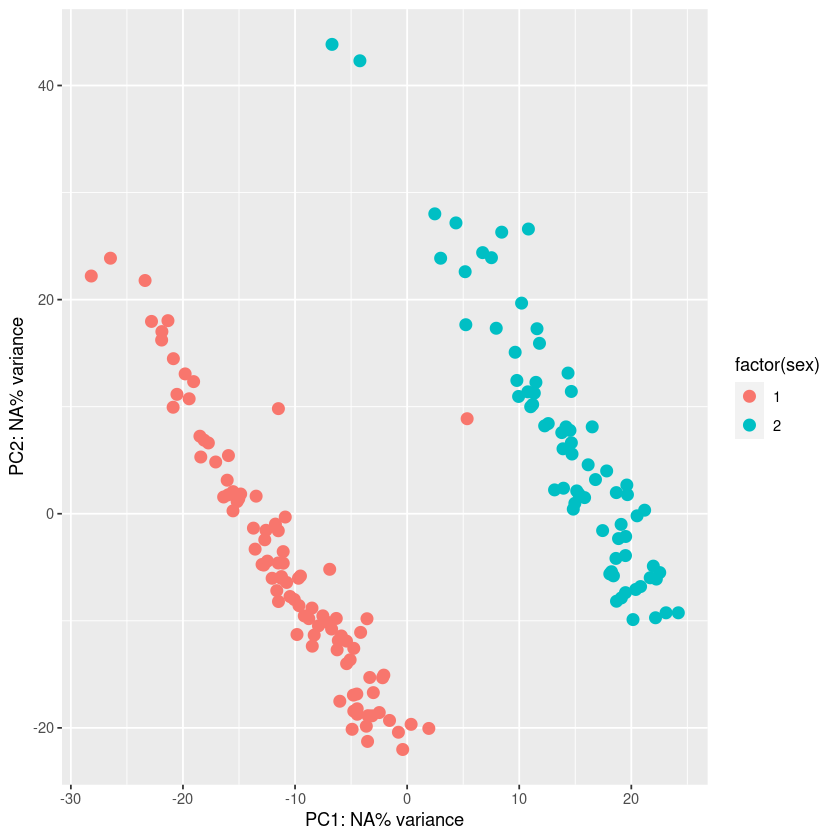

In [12]:
data <- plotPCA(vsd, intgroup = c("del"), returnData=TRUE)
data$sample <- rownames(data)
data <- merge(data, gtex.df, by="sample", all.x=TRUE)
percentVar <- round(100 * attr(data, "percentVar"))

colnames(data)
ggplot(data, aes(PC1, PC2, color=factor(sex))) + geom_point(size=3) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance"))

In [13]:
dds <- DESeq(dds)
design.df$size.factor <- sizeFactors(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 758 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [14]:
res <- results(dds)
summary(res)

res.df <- as.data.frame(res)
res.df$gene <- gene.ids
head(res.df[order(res.df$pvalue),],10)


out of 56010 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2, 0.0036%
LFC < 0 (down)     : 17, 0.03%
outliers [1]       : 0, 0%
low counts [2]     : 25792, 46%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
78,28209.487194,-1.8563438,0.1522541,-12.192405,3.411990e-34,1.031069e-29,ENSG00000282667.1
361000,3111.284270,-1.7305651,0.2365243,-7.316647,2.542432e-13,3.841488e-09,ENSG00000237973.1
371000,2304.522787,-2.3044152,0.3297205,-6.988995,2.768622e-12,2.788833e-08,ENSG00000278791.1
17492,13.550942,-1.2829039,0.2415480,-5.311176,1.089203e-07,6.945872e-04,ENSG00000198868.3
17493,7.807513,-1.5370047,0.2899843,-5.300303,1.156104e-07,6.945872e-04,ENSG00000263963.1
44016,62.219969,-0.6887078,0.1307340,-5.268010,1.379107e-07,6.945872e-04,ENSG00000272808.4
44017,10.843645,-0.8542675,0.1788805,-4.775633,1.791425e-06,7.733581e-03,ENSG00000259604.5
31529,123.724460,-0.9650849,0.2078129,-4.644010,3.417117e-06,1.290773e-02,ENSG00000187908.20
28557,152.600047,-0.8159311,0.1888060,-4.321531,1.549506e-05,5.202723e-02,ENSG00000119508.18


In [15]:
na.omit(res.df[res.df$gene %in% c(PRSS1, PRSS3P1, PRSS3P2, TRY7, PRSS2),])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
76,1758724.5410,0.1257197,0.12842300,0.9789502,3.276046e-01,9.999861e-01,ENSG00000274247.4
77,785.4033,-0.0478563,0.11826878,-0.4046401,6.857420e-01,9.999861e-01,ENSG00000282295.1
78,28209.4872,-1.8563438,0.15225411,-12.1924054,3.411990e-34,1.031069e-29,ENSG00000282667.1
79,1545.9653,-0.1026628,0.11114953,-0.9236461,3.556706e-01,9.999861e-01,ENSG00000282565.1
80,2090292.2810,-0.1386628,0.09822648,-1.4116644,1.580488e-01,9.999861e-01,ENSG00000282049.1


In [20]:
prss3p2 <- rownames(res)[which(as.character(res.df$gene) == PRSS3P2)[1]]

gene.counts <- plotCounts(dds, gene=prss3p2, intgroup=c("del"), returnData = TRUE)
gene.counts$sample <- rownames(gene.counts)
temp.df <- as.data.frame(t(alt.read.counts[alt.read.counts$feature==PRSS3P2,][2:ncol(alt.read.counts)]))
colnames(temp.df) <- c("raw_count")

temp.df$sample <- rownames(temp.df)

plot.df <- merge(gene.counts, temp.df, by="sample", all.x=TRUE)

ggplot(plot.df, aes(x = raw_count, y = count, color = factor(del))) +
  scale_y_log10() +  geom_point() + theme_bw()

ERROR: Error in t(alt.read.counts[alt.read.counts$feature == PRSS3P2, ][2:ncol(alt.read.counts)]): object 'alt.read.counts' not found


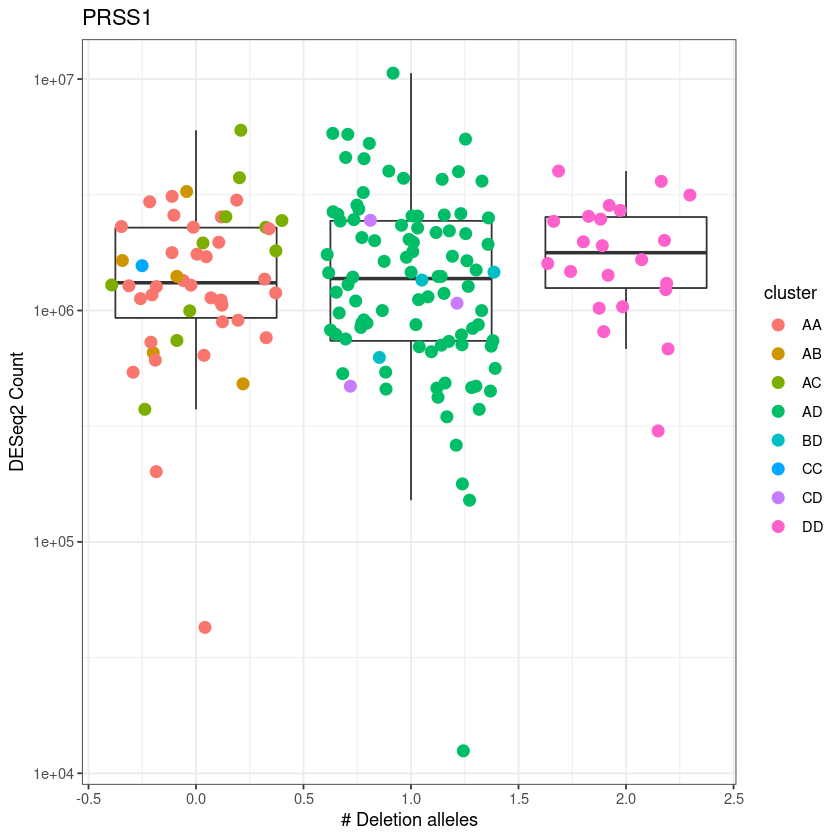

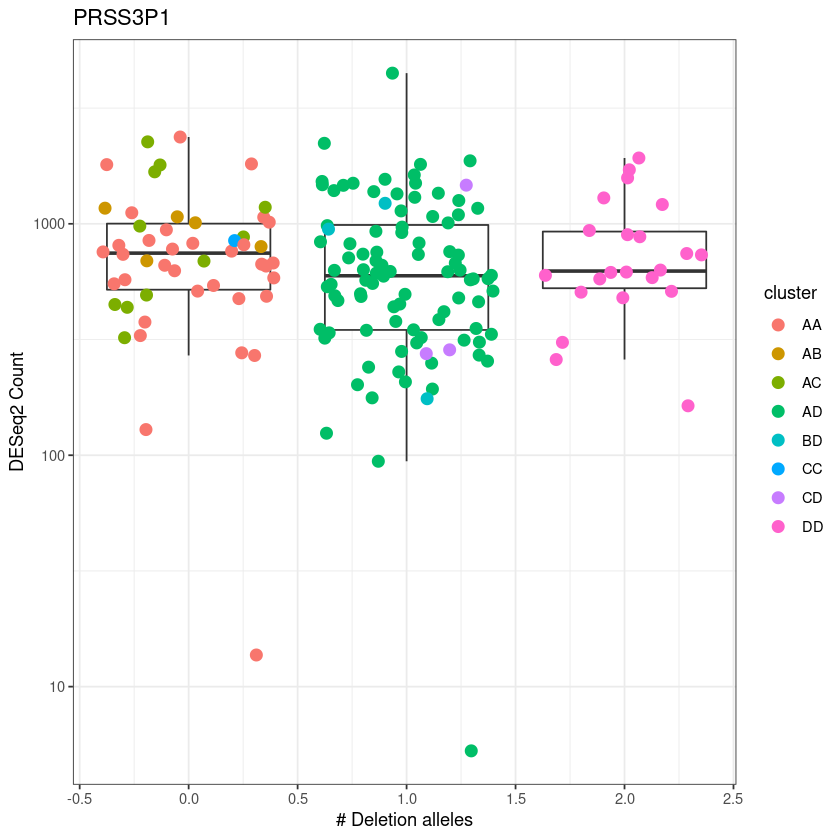

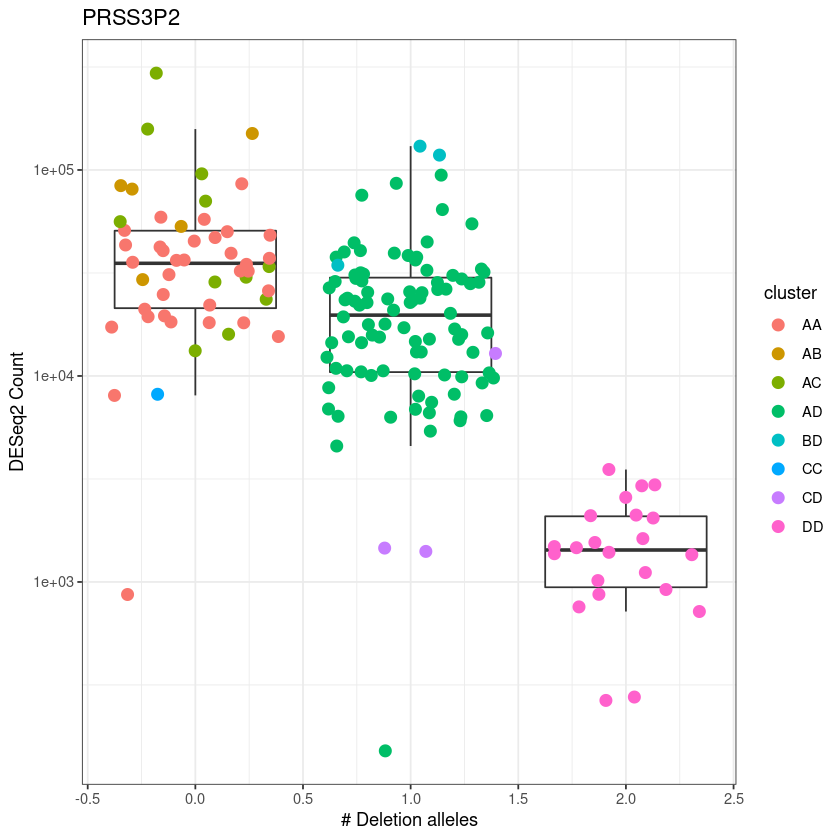

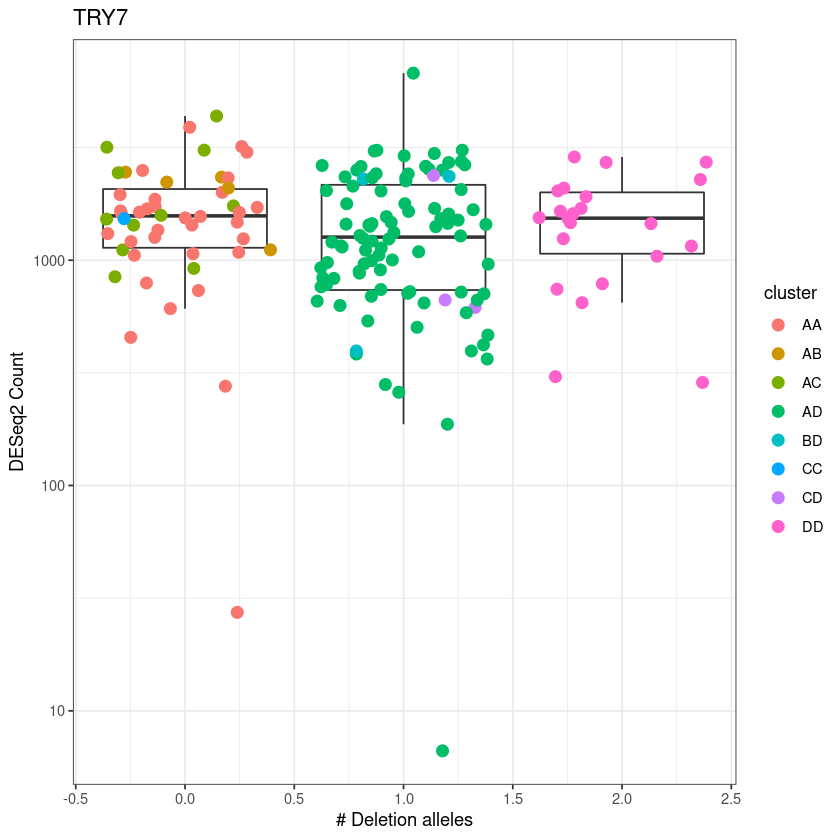

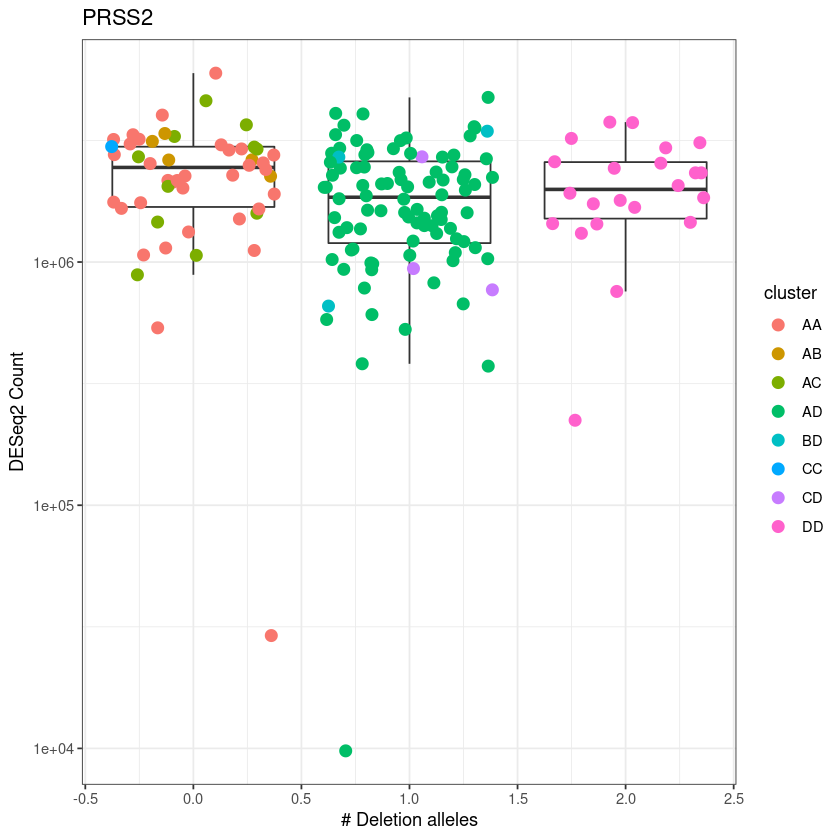

In [21]:
plot_gene <- function(gene.id, gene.name){
    target.gene <- rownames(res)[which(as.character(res.df$gene) == gene.id)[1]]

    gene.counts <- plotCounts(dds, gene = target.gene, intgroup=c("del"), returnData = TRUE)
    gene.counts$sample <- rownames(gene.counts)

    gene.df <- merge(gene.counts, design.df, by=c("sample","del"), all.x=TRUE)
    p <- ggplot(gene.df, aes(x=del, y=count, group=del)) + theme_bw() +
      scale_y_log10() +  geom_boxplot(outlier.alpha = 0) +
      geom_point(size=3, aes(color=cluster), position = position_jitter()) +
      labs(y="DESeq2 Count", x="# Deletion alleles") + ggtitle(gene.name)
    return(p)
}

plot_gene(PRSS1, "PRSS1")
plot_gene(PRSS3P1, "PRSS3P1")
plot_gene(PRSS3P2, "PRSS3P2")
plot_gene(TRY7, "TRY7")
plot_gene(PRSS2, "PRSS2")

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
78,28209.487194,-1.8563438,0.1522541,-12.192405,3.411990e-34,1.031069e-29,ENSG00000282667.1
361000,3111.284270,-1.7305651,0.2365243,-7.316647,2.542432e-13,3.841488e-09,ENSG00000237973.1
371000,2304.522787,-2.3044152,0.3297205,-6.988995,2.768622e-12,2.788833e-08,ENSG00000278791.1
17492,13.550942,-1.2829039,0.2415480,-5.311176,1.089203e-07,6.945872e-04,ENSG00000198868.3
17493,7.807513,-1.5370047,0.2899843,-5.300303,1.156104e-07,6.945872e-04,ENSG00000263963.1
44016,62.219969,-0.6887078,0.1307340,-5.268010,1.379107e-07,6.945872e-04,ENSG00000272808.4
44017,10.843645,-0.8542675,0.1788805,-4.775633,1.791425e-06,7.733581e-03,ENSG00000259604.5
31529,123.724460,-0.9650849,0.2078129,-4.644010,3.417117e-06,1.290773e-02,ENSG00000187908.20
28557,152.600047,-0.8159311,0.1888060,-4.321531,1.549506e-05,5.202723e-02,ENSG00000119508.18


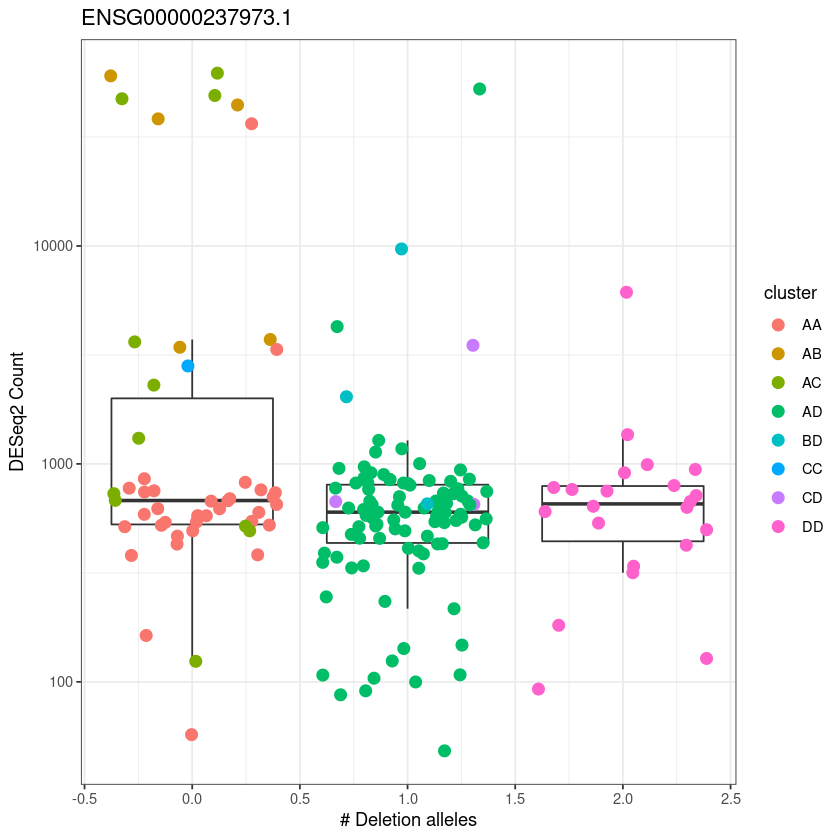

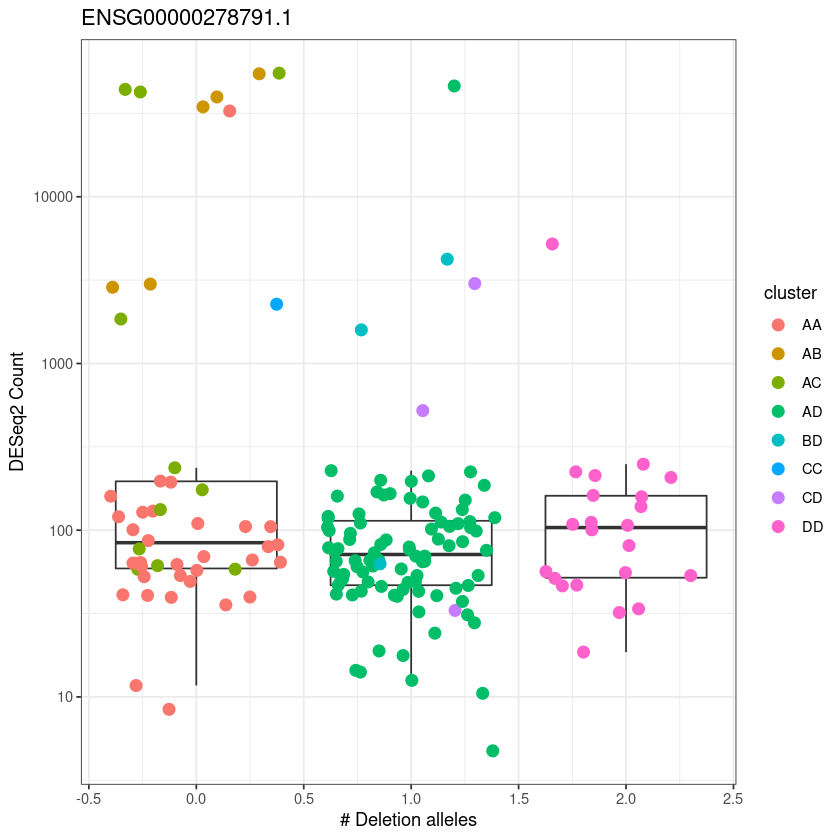

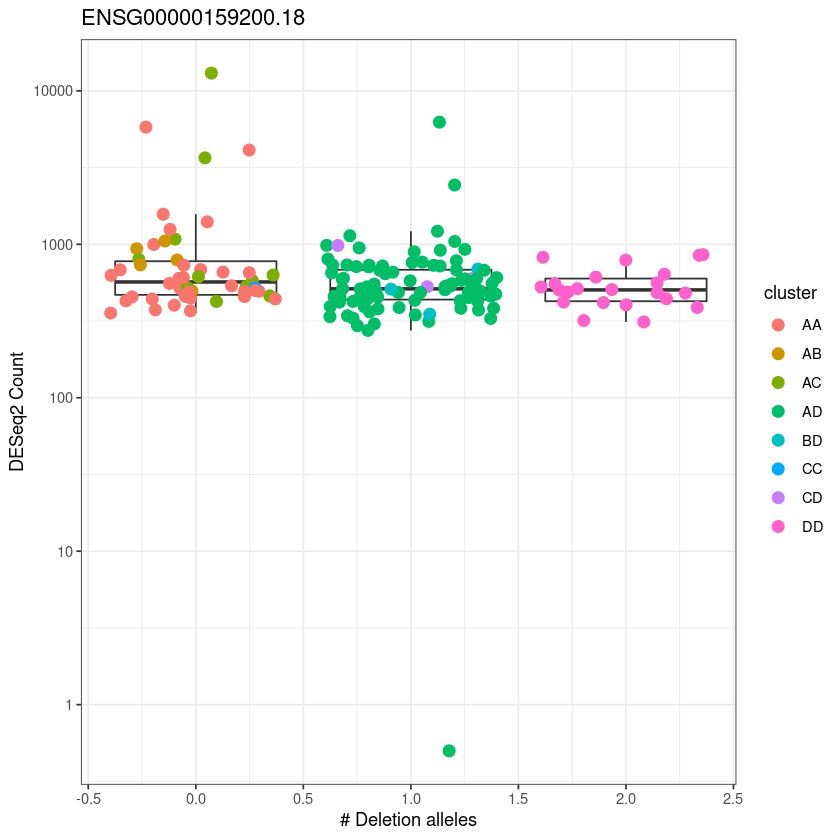

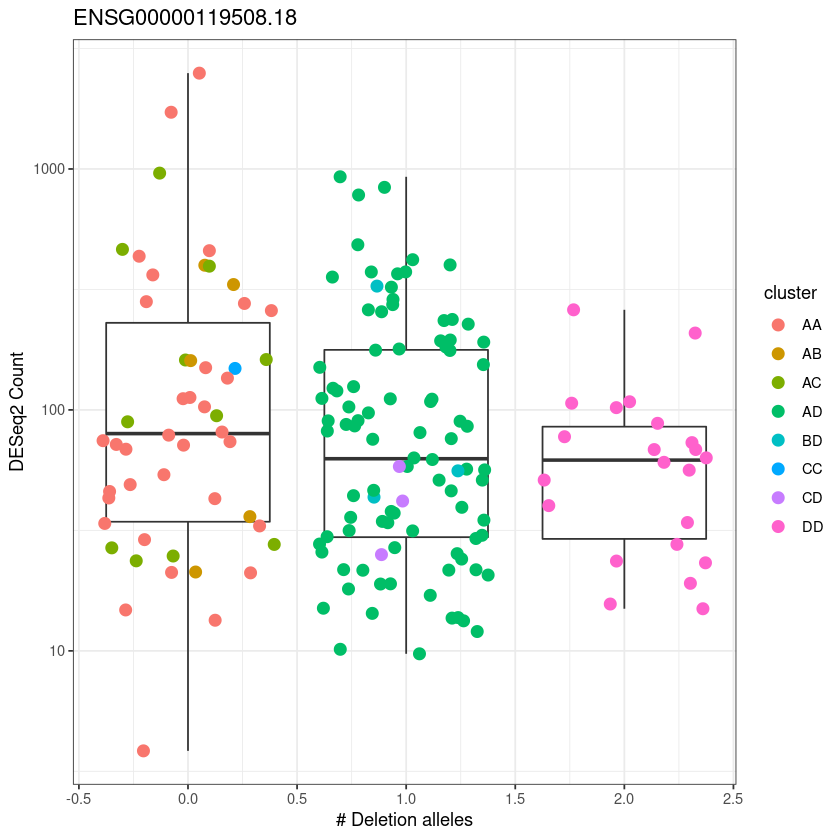

In [22]:
res.df <- as.data.frame(res)
res.df$gene <- gene.ids
head(res.df[order(res.df$pvalue),],10)

plot_gene("ENSG00000237973.1", "ENSG00000237973.1")
plot_gene("ENSG00000278791.1", "ENSG00000278791.1")
plot_gene("ENSG00000159200.18", "ENSG00000159200.18")
plot_gene("ENSG00000119508.18", "ENSG00000119508.18")

In [23]:
genes.bed <- read.csv("data/gencode.v35.alt.gtf", sep = "\t", header = FALSE)
colnames(genes.bed) <- c("chr", "source", "feature", "start", "end", 
                         "score", "strand", "frame", "attribute")

gene_id <- sapply(genes.bed$attribute, FUN=function(x) strsplit(as.character(x), ";")[[1]][1])
gene.id <- sapply(gene_id, FUN=function(x) strsplit(as.character(x), " ")[[1]][2])

genes.bed$gene <- gene.id
genes.bed <- genes.bed[genes.bed$gene %in% GENES & genes.bed$feature == "exon",]

window=5

starts=GRanges(seqnames="chr7_KI270803v1_alt", strand=c("+"),
           ranges=IRanges(start=genes.bed$end - window, end=genes.bed$end + window))
ends=GRanges(seqnames="chr7_KI270803v1_alt", strand=c("+"),
           ranges=IRanges(start=genes.bed$start - window, end=genes.bed$start + window))

hs <- findOverlaps(starts, starts)
starts <- reduce(c(starts[queryHits(hs)], starts[subjectHits(hs)]))
he <- findOverlaps(ends, ends)
ends <- reduce(c(ends[queryHits(he)], ends[subjectHits(he)]))

junction.set <- do.call(rbind, lapply(1:length(start(ends)), 
                FUN=function(i) data.frame(s1=start(starts), 
                                           s2=end(starts),
                                           e1=start(ends)[i],
                                           e2=end(ends)[i])))

junction.set <- junction.set[junction.set$s2 < junction.set$e1,]
junction.set <- junction.set %>% distinct()

print(paste("rows:", nrow(junction.set)))
head(junction.set)

[1] "rows: 500"


,s1,s2,e1,e2
,<int>,<int>,<int>,<int>
1,752116,752126,753147,753157
2,752116,752126,753221,753231
3,752116,752126,753257,753267
4,752116,752126,753661,753671
5,753306,753316,753661,753671
6,752116,752126,753702,753712


In [24]:
source("helper.R")

get_junctions <- function(file){
    junction <- read.table(file, header=TRUE, sep=" ")
    junction.df <- junction[junction$PrimaryGene %in% GENES | junction$SecondaryGenes %in% GENES,]
    colnames(junction.df) <- c("gene1", "gene2", "chr1", "pos1", "strand1", 
                               "chr2", "pos2", "strand2", "count")
    junction.df <- junction.df[,c("gene1", "gene2", "pos1", "pos2", "count")]
    junction.df[junction.df$pos1 > 752000 & junction.df$pos2 < 797500 &
                junction.df$pos1 > 752000 & junction.df$pos2 < 797500,]

    return( junction.df )
}

junction_run_name <- function(file){
    dir.split <- unlist(strsplit(file, "/"))
    file.split <- unlist(strsplit(dir.split[length(dir.split)], "\\."))
    return(file.split[1])
}

junctions <- lapply(Sys.glob(junctions.txt), get_junctions)
junction.runs <- sapply(Sys.glob(junctions.txt), junction_run_name)
junction.df <- data.frame(run=junction.runs)
junction.df <- merge(merge(junction.df, run.df, by="run", all.x=TRUE), design.df, by="sample", all.x=TRUE)
junction.df <- junction.df[order(match(junction.df$run.x, junction.runs)),]


In [25]:
junction_vector <- function(df){
    count_junctions <- function(i){
        js <- junction.set[i,]
        olap <- df[df$pos1 >= js$s1 & df$pos1 <= js$s2 &
                    df$pos2 >= js$e1 & df$pos2 <= js$e2,]
        if (nrow(olap) < 1) { return (0) }
        return(sum(olap$count))
    }
    return(sapply(1:nrow(junction.set), count_junctions))
}

junction.mat <- do.call(rbind, lapply(junctions, junction_vector))
total <- sum(sapply(junctions, FUN=function(x) sum(x$count)))
accounted <- sum(junction.mat)

print(paste(accounted, "/", total, "=", round(accounted / total, 4), "% of junctions accounted for."))

[1] "508648491 / 515781103 = 0.9862 % of junctions accounted for."


,sample,run.x,assay.type.x,cluster,posterior,run.y,assay.type.y,predict,sex,age,DTHHRDY,del,size.factor
,<chr>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<chr>,<fct>,<fct>,<fct>,<int>,<dbl>
80,GTEX.PWOO,SRR1069352,RNA-Seq,AA,1.0000000,SRR2165567,WGS,AA,2,40-49,0,0,1.3066690
128,GTEX.WFON,SRR1070403,RNA-Seq,AD,1.0000000,SRR2166348,WGS,AD,1,40-49,0,1,1.2745724
153,GTEX.XYKS,SRR1070764,RNA-Seq,BD,0.9874115,SRR2167592,WGS,BD,2,60-69,0,1,1.9091203
82,GTEX.Q2AH,SRR1071519,RNA-Seq,AC,0.9787433,SRR2165161,WGS,AC,1,40-49,0,0,1.2100994
90,GTEX.QLQW,SRR1072007,RNA-Seq,CD,0.9592219,SRR2167165,WGS,CD,1,30-39,0,1,0.6768757
146,GTEX.XMK1,SRR1072104,RNA-Seq,AD,1.0000000,SRR2164514,WGS,AD,1,40-49,0,1,1.2317698


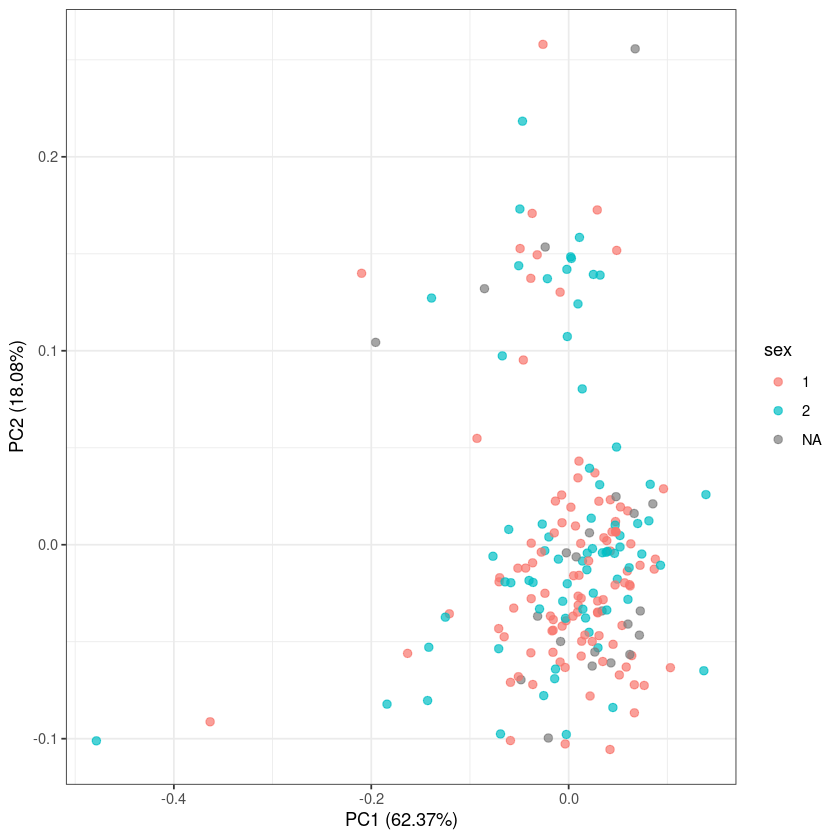

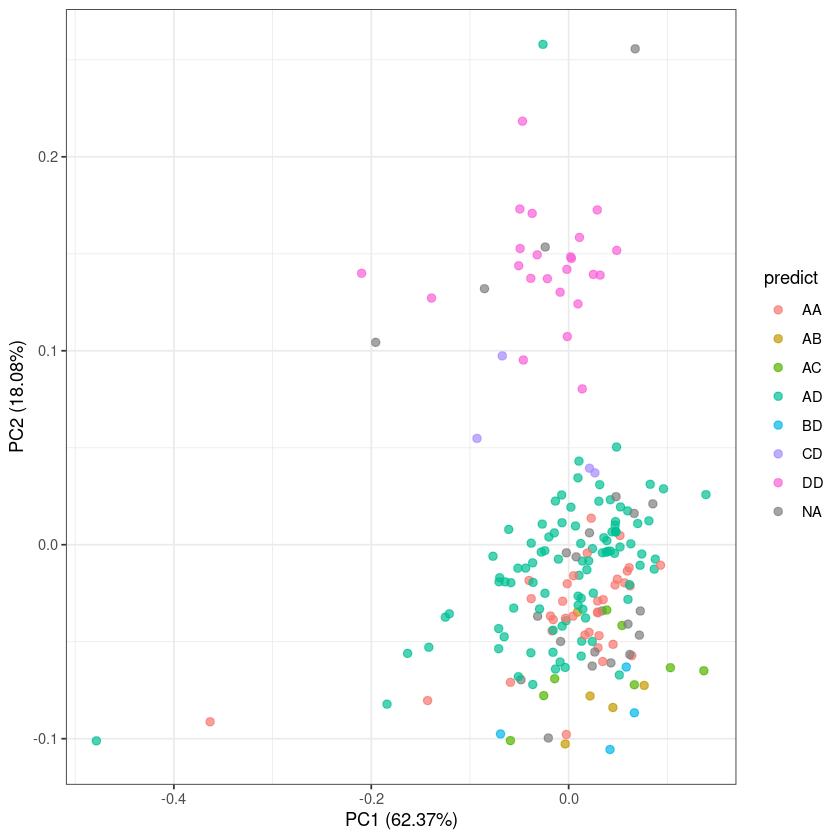

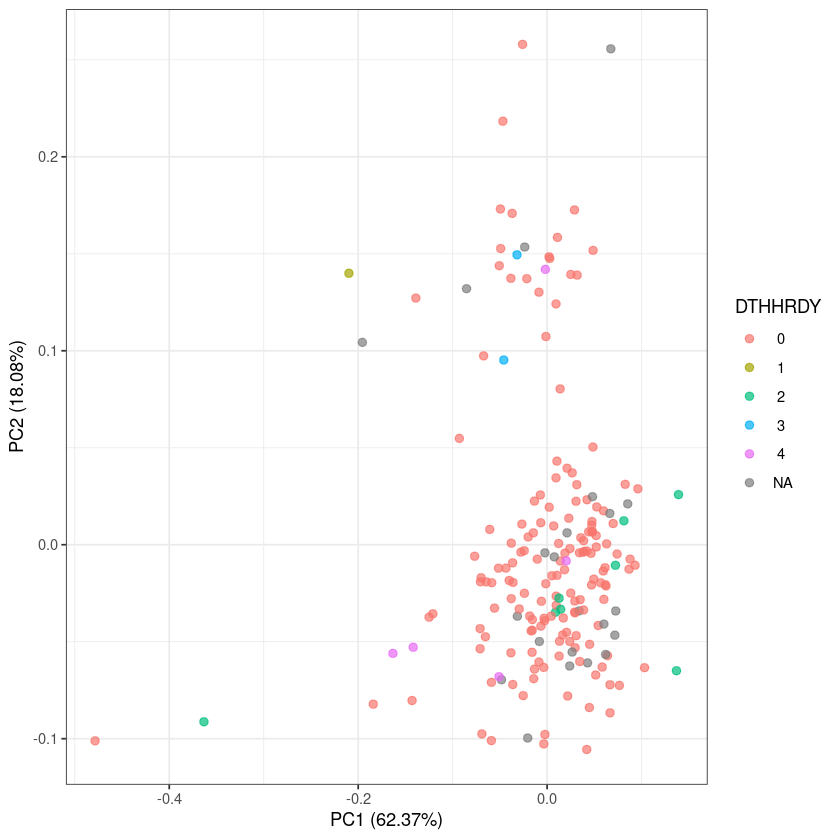

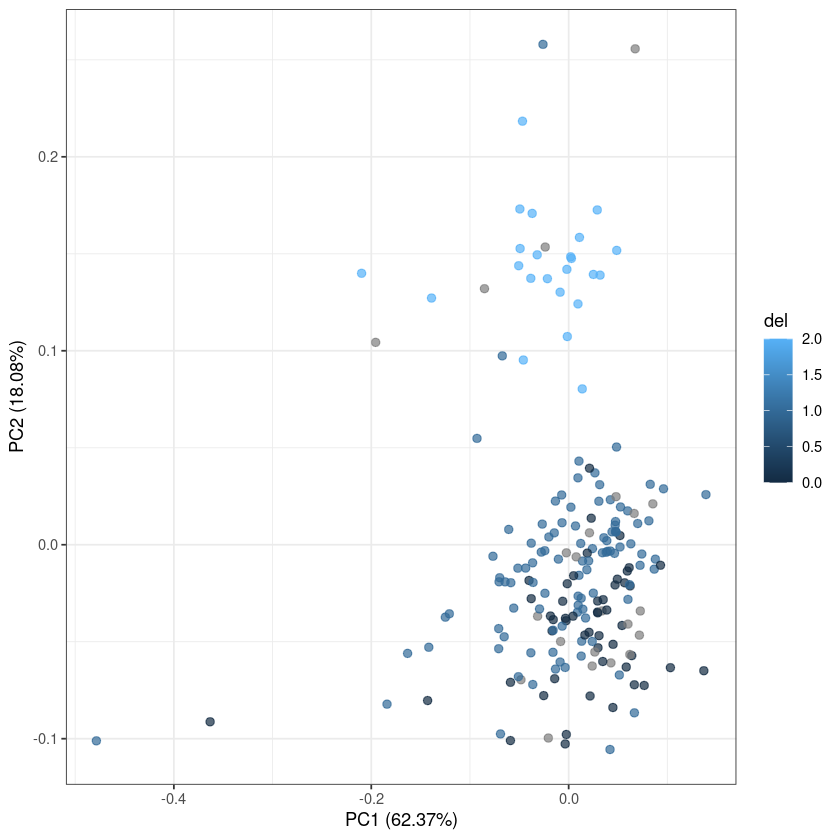

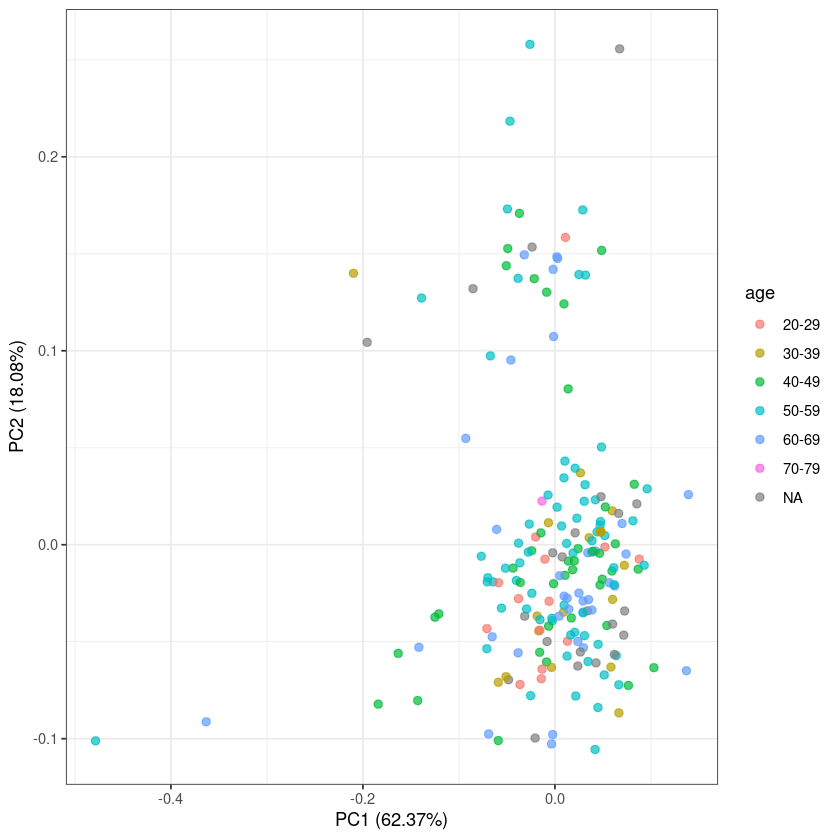

In [26]:
#hist(log10(junction.mat))

scale <- junction.df$size.factor
scale[is.na(scale)] <- 1

jm <- junction.mat+1
jm <- apply(jm, 2, "/", scale)
jm <- jm[,colVars(jm) > 10]
jm <- jm[,colMeans(jm) > 1000]

jm <- log10(jm+1)
pca <- prcomp(jm, scale.=TRUE)
head(junction.df)

autoplot(pca, size=2, alpha=0.7, data=junction.df, colour="sex") + theme_bw()
autoplot(pca, size=2, alpha=0.7, data=junction.df, colour="predict") + theme_bw()
autoplot(pca, size=2, alpha=0.7, data=junction.df, colour="DTHHRDY") + theme_bw()
autoplot(pca, size=2, alpha=0.7, data=junction.df, colour="del") + theme_bw()
autoplot(pca, size=2, alpha=0.7, data=junction.df, colour="age") + theme_bw()



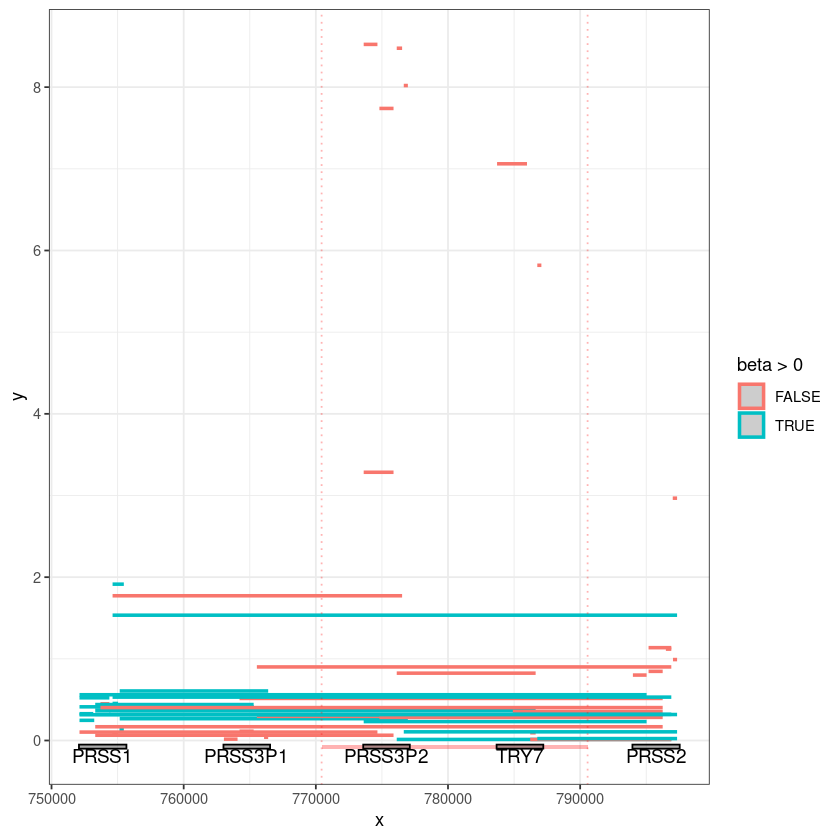

In [27]:
scale <- junction.df$size.factor
scale[is.na(scale)] <- 1

jm <- junction.mat+1
jm <- apply(jm, 2, "/", scale)
keep <- colVars(jm) > 10 & colMaxs(jm) > 100
jm <- jm[,keep]
js <- junction.set[keep,]
regress_junctions <- function(i, target="D"){
    
    count <- jm[,i]
    del <- junction.df$del
    hap <- str_count(junction.df$cluster, pattern=target)

    model=glm(round(count) ~ hap + del)
    
    coef <- summary(model)$coefficients
    df <- data.frame(beta=coef[,1], p=coef[,4])
    j <- js[i,]
    df$s1 <- j$s1 ; df$s2 <- j$s2
    df$e1 <- j$e1 ; df$e2 <- j$e2
    df$var <- row.names(df)
    df$mean <- mean(count)
    df$i<-i
    rownames(df) <- NULL
    df <- df[df$var == "hap",]
    return(df)
}  

junction.regress.df <- do.call(rbind, lapply(1:ncol(jm), regress_junctions))
junction.regress.df$logp <- -log10(junction.regress.df$p)

p <- ggplot(junction.regress.df) +
    geom_rect(junction.regress.df, alpha=0.3, size=1, 
        mapping=aes(xmin=s1, xmax=e2, ymin=-log10(p), ymax=-log10(p), color=beta>0)) +
     theme_bw()
p <- add_gene_rectangles(p)
p
#head(junction.regress.df[order(junction.regress.df$p),], 20)

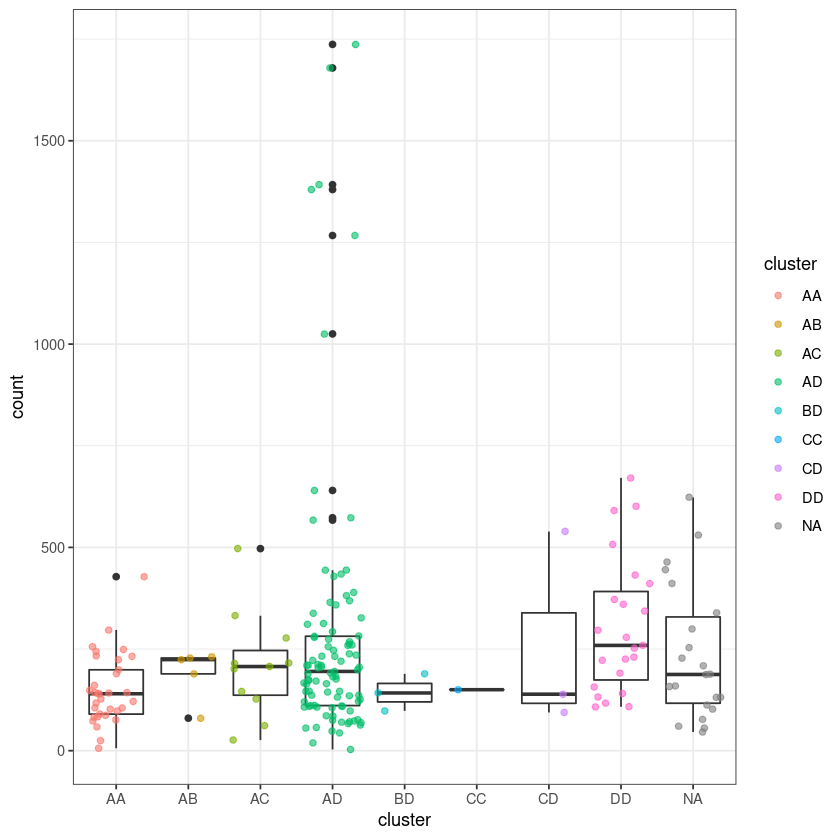

In [28]:

ploti <- function(i){
    df <- data.frame(del=junction.df$del, count=round(jm[,i]), cluster=junction.df$cluster)
    p <- ggplot(df, aes(x=cluster, y=count, group=cluster)) +
    geom_boxplot() + geom_point(aes(colour=cluster), alpha=0.6, position = "jitter") + theme_bw()
    return(p)
}
ploti(9)



In [29]:
head(junction.regress.df[order(junction.regress.df$p),], 20)


,beta,p,s1,s2,e1,e2,var,mean,i,logp
,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>
218,-2867.285142,2.995738e-09,773620,773630,774650,774660,hap,3.460003e+03,19,8.5234961
223,-4069.257580,3.338633e-09,776121,776131,776517,776527,hap,4.939144e+03,24,8.4764313
225,-3218.980456,9.557150e-09,776653,776663,776953,776963,hap,3.861062e+03,26,8.0196716
221,-3832.419444,1.822854e-08,774809,774819,775868,775878,hap,4.578714e+03,22,7.7392481
228,-14.655224,8.682946e-08,783712,783722,785967,785977,hap,2.002818e+01,29,7.0613329
233,-21.425708,1.517566e-06,786757,786767,787055,787065,hap,6.075817e+01,34,5.8188524
220,-5.319218,5.194428e-04,773620,773630,775868,775878,hap,6.157069e+00,21,3.2844623
255,-62.898271,1.078387e-03,797006,797016,797324,797334,hap,1.209315e+02,56,2.9672252
28,78.228013,1.218072e-02,754619,754629,755460,755470,hap,2.472244e+02,9,1.9143270


In [30]:
plot_junctions <- function(target.genes, min.count=10000, get.df=FALSE){

    jdf <- junction.df[junction.df$countSum > min.count,]
    jdf <- jdf[(jdf$PrimaryGene %in% target.genes | jdf$SecondaryGenes %in% target.genes), ]
    jdf <- jdf[!is.na(jdf$PrimaryGene), ]

    if (get.df){ return (jdf) }
    
    p <- ggplot(jdf) +
        geom_rect(jdf, mapping=aes(xmin=Site1_location, 
                                           xmax=Site2_location,
                                           ymin=log10(countSum), 
                                           ymax=log10(countSum)), color="grey", alpha=1) +
        geom_point(jdf, mapping=aes(x=Site1_location, y=log10(countSum))) + 
        geom_point(jdf, mapping=aes(x=Site2_location, y=log10(countSum))) + 

        xlim(750000, 800000) + theme_bw()
    
    p <- add_gene_rectangles(p, label=FALSE)
    return(p)
}

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'countSum' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste

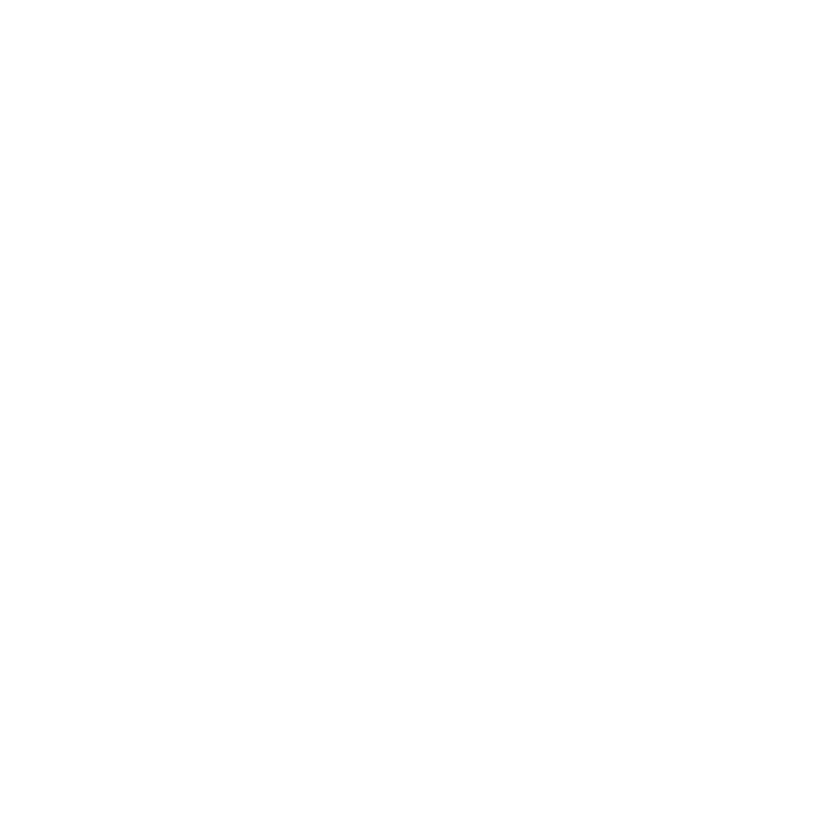

In [31]:
plot_junctions(PRSS3P2)
plot_junctions(GENES, min.count=70000)

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'countSum' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste

sample,run.x,assay.type.x,cluster,posterior,run.y,assay.type.y,predict,sex,age,DTHHRDY,del,size.factor
<chr>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<chr>,<fct>,<fct>,<fct>,<int>,<dbl>


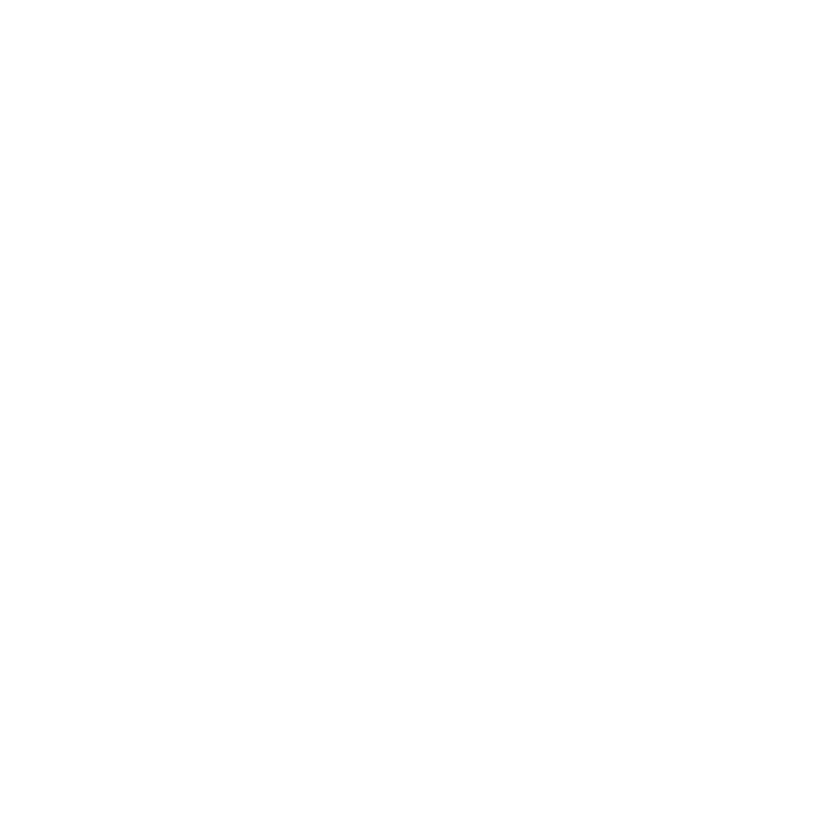

In [32]:
plot_junctions(PRSS3P2, min.count=10000)

plot_junctions(PRSS3P2, min.count=10000, get.df=TRUE)


In [33]:
s <- 774814
e <- 796239

get_junctions2 <- function(file){
    junction <- read.table(file, header=TRUE, sep=" ")
    junction.df <- junction[junction$Site1_location == s & junction$Site2_location == e,]
    colnames(junction.df)[ncol(junction.df)] <- "count"
    junction.df$file <- file
    return( junction.df )
}

junctions2 <- do.call(rbind, 
                        lapply(Sys.glob("/media/scott/Zapdos/gtex/junctions/*.alt.junction.counts.txt"), 
                        get_junctions2))

In [34]:
junctions2[order(-junctions2$count),]

ERROR: Error in -junctions2$count: invalid argument to unary operator


In [97]:
f <- function(vid, i) {
    x <- strsplit(as.character(vid), '_')
    return(x[[1]][length(x[[1]]) - i])
}

pdf <- pair.df

pdf$alt <- sapply(pdf$variant_id, FUN=f, i=0)
pdf$ref <- sapply(pdf$variant_id, FUN=f, i=1)
pdf$pos <- sapply(pdf$variant_id, FUN=f, i=2)

pdf$gene_id <- as.character(pdf$gene_id)
pdf$pos <- as.numeric(pdf$pos)

pdf <- pdf[pdf$gene_id %in% GENES,]

pdf$gene_id[pdf$gene_id == PRSS1] <- "PRSS1"
pdf$gene_id[pdf$gene_id == PRSS3P1] <- "PRSS3P1"
pdf$gene_id[pdf$gene_id == PRSS3P2] <- "PRSS3P2"
pdf$gene_id[pdf$gene_id == TRY7] <- "TRY7"
pdf$gene_id[pdf$gene_id == PRSS2] <- "PRSS2"

head(pdf)

,gene_id,variant_id,tss_distance,ma_samples,ma_count,maf,pval_nominal,slope,slope_se,alt,ref,pos
,<chr>,<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
5785,PRSS1,chr7_KI270803v1_alt_700361_C_T,-51704,115,151,0.48089200,0.502924,-0.0467447,0.0695313,T,C,700361
5786,PRSS1,chr7_KI270803v1_alt_700838_A_G,-51227,2,2,0.00636943,0.126688,-0.5982270,0.3884910,G,A,700838
5787,PRSS1,chr7_KI270803v1_alt_701105_G_A,-50960,114,150,0.47770700,0.421448,-0.0553640,0.0685905,A,G,701105
5788,PRSS1,chr7_KI270803v1_alt_701304_C_A,-50761,117,153,0.48726100,0.724506,-0.0247349,0.0699882,A,C,701304
5789,PRSS1,chr7_KI270803v1_alt_701475_C_A,-50590,97,126,0.40127400,0.663573,-0.0276787,0.0634461,A,C,701475
5790,PRSS1,chr7_KI270803v1_alt_701625_A_G,-50440,116,152,0.48407600,0.624121,-0.0338949,0.0689607,G,A,701625


In [2]:
p <- ggplot(pdf, aes(x=pos, y=-log10(pval_nominal), colour=gene_id)) +
  geom_point() + theme_bw() + facet_wrap(~gene_id, scales="free_y") + 
  xlab("Position") + ylab("-log10( p-value )") + labs(colour = "Gene")
add_gene_rectangles(p, label=FALSE)

single_plot <- function(gene){
    p <- ggplot(pdf[pdf$gene_id==gene & pdf$pval_nominal < 0.05,], aes(x=pos, y=-log10(pval_nominal), colour=maf)) +
      geom_point() + theme_bw() +
      xlab("Position") + ylab("-log10( p-value )") + labs(colour = "Slope")
    p <- add_gene_rectangles(p, label=FALSE)
    return(p)
}

single_plot("PRSS1")
single_plot("PRSS2")

vdf <- pdf[pdf$gene_id=="PRSS1",]
head(vdf[order(vdf$pval_nominal),])

ERROR: Error in ggplot(pdf, aes(x = pos, y = -log10(pval_nominal), colour = gene_id)): could not find function "ggplot"


ERROR: Error in eval(expr, envir, enclos): object 'cdf' not found
